In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Run NN model to predict the full price
write a short summery here

In [2]:
# Load the data
df1 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_clean_df_05_07.csv")
df2 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_clean_df_20_06.csv")
df3 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_clean_df_25_06.csv")

# Merge the dataframes
df = pd.concat([df1, df2, df3], ignore_index=True)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


C:\Users\User\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
36 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 749, in fit
    return self._fit(X, y, incremental=False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", 

Results for Neural Network Regressor:
{'Model': 'Neural Network Regressor', 'Train R2': 0.7537932907101661, 'Train RMSE': 198.76031320807618, 'Train MSE': 39505.66210657254, 'Train MAE': 139.7766374716081, 'Test R2': 0.755191184359964, 'Test RMSE': 198.2060758729896, 'Test MSE': 39285.64851296931, 'Test MAE': 139.83398304884997, 'Train Size': 56854, 'Test Size': 24367, 'Best Parameters': {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}}


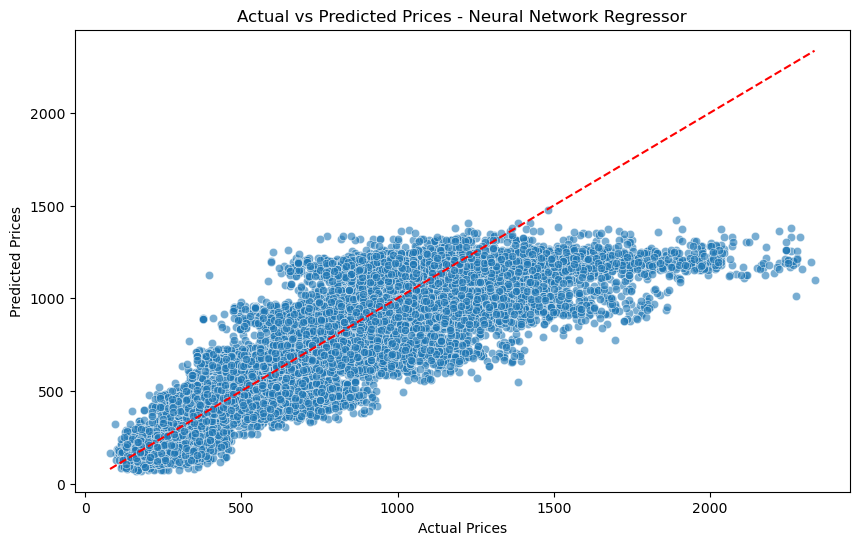

In [3]:
# Function to run Neural Network Regression and calculate metrics
def run_neural_network_regressor(df):
     # Remove columns that are not needed for regression
    columns_to_use = ['TTT', 'LOS', 'score',
           'reviews', 'full_price',
           'Free_cancellation', 'No_payment', 'Breakfast', 'Option Member',
           'star_rating', 'location_rating',
           'km_from_center']
    df = df[columns_to_use]
    
    # Keep only numeric columns
    df = df.select_dtypes(include=[np.number])
    
    # Remove columns with all NaN values
    df = df.dropna(axis=1, how='all')
    
    # Ensure there are no remaining NaN values
    imputer = SimpleImputer(strategy='mean')
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # Split the data into train and test sets
    X = df.drop(columns=['full_price'])
    y = df['full_price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Define the parameter grid for GridSearchCV
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }
    
    # Initialize Neural Network Regressor with GridSearchCV
    model = MLPRegressor(max_iter=500, random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    # Best model from GridSearchCV
    best_model = grid_search.best_estimator_
    
    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Training metrics
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    # Test metrics
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    results = {
        'Model': 'Neural Network Regressor',
        'Train R2': train_r2,
        'Train RMSE': train_rmse,
        'Train MSE': train_mse,
        'Train MAE': train_mae,
        'Test R2': test_r2,
        'Test RMSE': test_rmse,
        'Test MSE': test_mse,
        'Test MAE': test_mae,
        'Train Size': len(X_train),
        'Test Size': len(X_test),
        'Best Parameters': grid_search.best_params_
    }
    
    return results, y_test, y_test_pred

# Run Neural Network Regressor
results, y_test, y_test_pred = run_neural_network_regressor(df)

# Display results
print("Results for Neural Network Regressor:")
print(results)

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices - Neural Network Regressor')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()

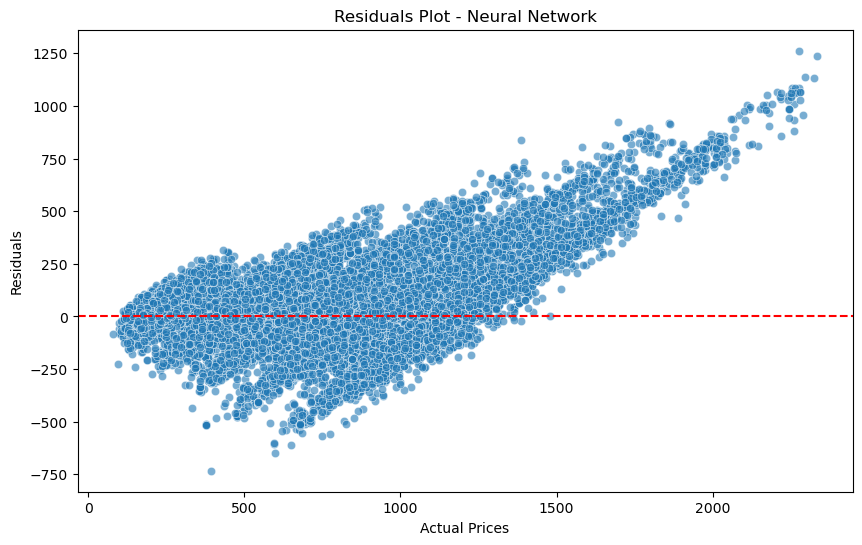

In [4]:
# Residual plot
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Residuals')
plt.title(f'Residuals Plot - Neural Network')
plt.show()

# Run neural network model after features engineering to predict the full price

In [6]:
# Load the data
df1 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_clean_df_features_engineering_20_06.csv")
df2 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_clean_df_features_engineering_25_06.csv")
df3 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_clean_df_features_engineering_05_07.csv")

# Merge the dataframes
df = pd.concat([df1, df2, df3], ignore_index=True)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


C:\Users\User\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
36 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 749, in fit
    return self._fit(X, y, incremental=False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", 

Results for Neural Network Regressor with features engineering:
{'Model': 'Neural Network Regressor', 'Train R2': 0.8523248216310618, 'Train RMSE': 142.5743510600175, 'Train MSE': 20327.445580185118, 'Train MAE': 102.20620575322386, 'Test R2': 0.849312874401001, 'Test RMSE': 142.51249233199394, 'Test MSE': 20309.810470676635, 'Test MAE': 102.39767938627202, 'Train Size': 29338, 'Test Size': 12574, 'Best Parameters': {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'solver': 'adam'}}


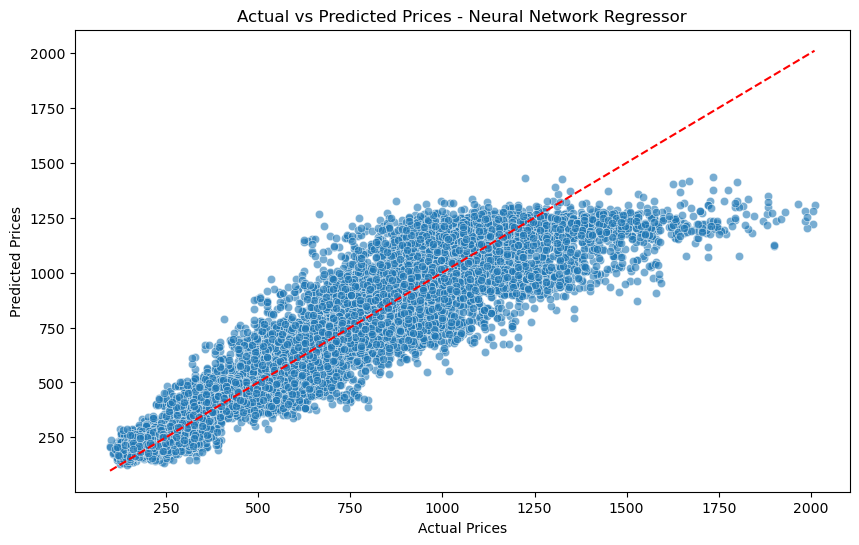

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Merge the dataframes
# df = pd.concat([df1, df2, df3], ignore_index=True)

# Function to run Neural Network Regression and calculate metrics
def run_neural_network_regressor(df):
    columns_to_use = ['TTT', 'LOS', 'score',
           'reviews', 'full_price',
           'Free_cancellation', 'No_payment', 'Breakfast', 'Option Member',
           'star_rating', 'location_rating',
           'km_from_center',
           'checkin_day', 'checkout_day', 'checkin_day_name_Friday',
           'checkin_day_name_Monday', 'checkin_day_name_Saturday',
           'checkin_day_name_Sunday', 'checkin_day_name_Thursday',
           'checkin_day_name_Tuesday', 'checkin_day_name_Wednesday',
           'checkin_day_name_nan', 'checkout_day_name_Friday',
           'checkout_day_name_Monday', 'checkout_day_name_Saturday',
           'checkout_day_name_Sunday', 'checkout_day_name_Thursday',
           'checkout_day_name_Tuesday', 'checkout_day_name_Wednesday',
           'checkout_day_name_nan', 'period_of_the_month_beginning of the month',
           'period_of_the_month_end of the month',
           'period_of_the_month_middle of the month']
    df = df[columns_to_use]
    
    # Keep only numeric columns
    df = df.select_dtypes(include=[np.number])
    
    # Remove columns with all NaN values
    df = df.dropna(axis=1, how='all')
    
    # Ensure there are no remaining NaN values
    imputer = SimpleImputer(strategy='mean')
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # Split the data into train and test sets
    X = df.drop(columns=['full_price'])
    y = df['full_price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Define the parameter grid for GridSearchCV
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }
    
    # Initialize Neural Network Regressor with GridSearchCV
    model = MLPRegressor(max_iter=500, random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    # Best model from GridSearchCV
    best_model = grid_search.best_estimator_
    
    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Training metrics
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    # Test metrics
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    results = {
        'Model': 'Neural Network Regressor',
        'Train R2': train_r2,
        'Train RMSE': train_rmse,
        'Train MSE': train_mse,
        'Train MAE': train_mae,
        'Test R2': test_r2,
        'Test RMSE': test_rmse,
        'Test MSE': test_mse,
        'Test MAE': test_mae,
        'Train Size': len(X_train),
        'Test Size': len(X_test),
        'Best Parameters': grid_search.best_params_
    }
    
    return results, y_test, y_test_pred

# Run Neural Network Regressor
results, y_test, y_test_pred = run_neural_network_regressor(df)

# Display results
print("Results for Neural Network Regressor with features engineering:")
print(results)

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices - Neural Network Regressor')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()

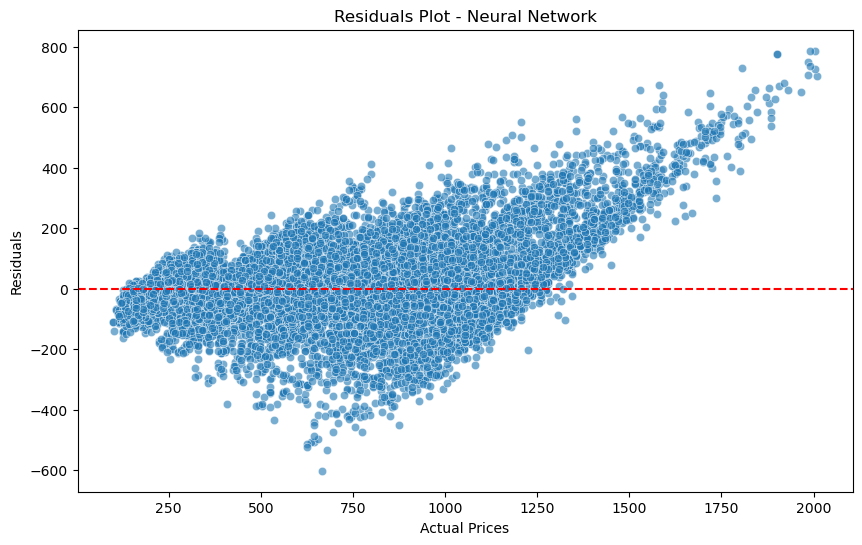

In [8]:
# Residual plot
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Residuals')
plt.title(f'Residuals Plot - Neural Network')
plt.show()

# Repeat the process but on data after normalization
1. Linear regression on normalized data
2. Linear regression on normalized data with features engineering

In [10]:
# Load the data
df1 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_normalized_data_05_07.csv")
df2 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_normalized_data_20_06.csv")
df3 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_normalized_data_25_06.csv")

# Merge the dataframes
df = pd.concat([df1, df2, df3], ignore_index=True)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Results for Neural Network Regressor after data normalization:
{'Model': 'Neural Network Regressor', 'Train R2': 0.9106670015438976, 'Train RMSE': 0.29853922261242416, 'Train MSE': 0.08912566743803055, 'Train MAE': 0.21379949897933376, 'Test R2': 0.8974451714454458, 'Test RMSE': 0.32108227581725196, 'Test MSE': 0.10309382784398587, 'Test MAE': 0.23102640101522515, 'Train Size': 29275, 'Test Size': 12547, 'Best Parameters': {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'solver': 'adam'}}


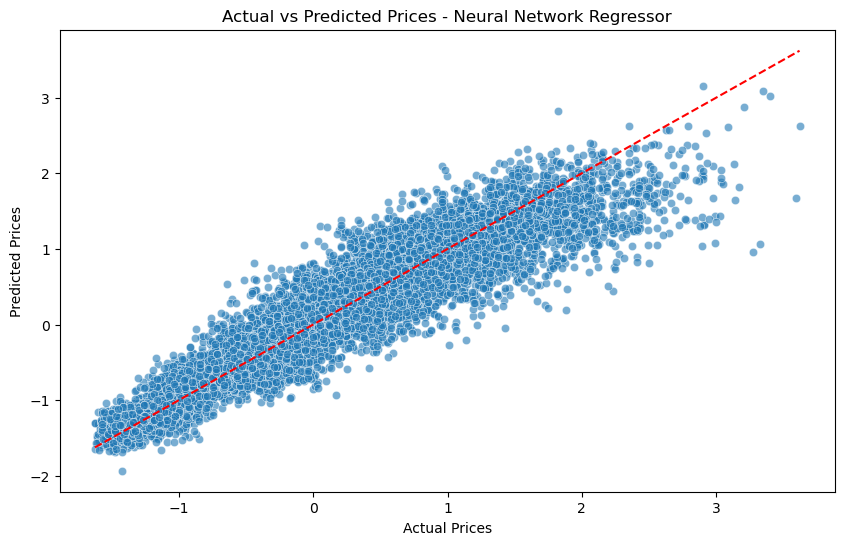

In [11]:
# Function to run Neural Network Regression and calculate metrics
def run_neural_network_regressor(df):
     # Remove columns that are not needed for regression
    columns_to_use = ['TTT', 'LOS', 'score',
           'reviews', 'full_price',
           'Free_cancellation', 'No_payment', 'Breakfast', 'Option Member',
           'star_rating', 'location_rating',
           'km_from_center']
    df = df[columns_to_use]
    
    # Keep only numeric columns
    df = df.select_dtypes(include=[np.number])
    
    # Remove columns with all NaN values
    df = df.dropna(axis=1, how='all')
    
    # Ensure there are no remaining NaN values
    imputer = SimpleImputer(strategy='mean')
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # Split the data into train and test sets
    X = df.drop(columns=['full_price'])
    y = df['full_price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Define the parameter grid for GridSearchCV
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }
    
    # Initialize Neural Network Regressor with GridSearchCV
    model = MLPRegressor(max_iter=500, random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    # Best model from GridSearchCV
    best_model = grid_search.best_estimator_
    
    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Training metrics
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    # Test metrics
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    results = {
        'Model': 'Neural Network Regressor',
        'Train R2': train_r2,
        'Train RMSE': train_rmse,
        'Train MSE': train_mse,
        'Train MAE': train_mae,
        'Test R2': test_r2,
        'Test RMSE': test_rmse,
        'Test MSE': test_mse,
        'Test MAE': test_mae,
        'Train Size': len(X_train),
        'Test Size': len(X_test),
        'Best Parameters': grid_search.best_params_
    }
    
    return results, y_test, y_test_pred

# Run Neural Network Regressor
results, y_test, y_test_pred = run_neural_network_regressor(df)

# Display results
print("Results for Neural Network Regressor after data normalization:")
print(results)

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices - Neural Network Regressor')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()

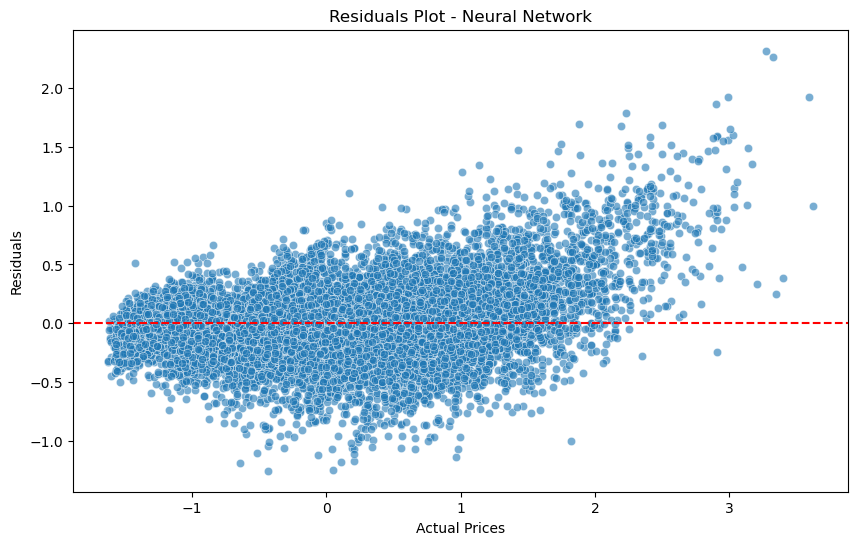

In [12]:
# Residual plot
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Residuals')
plt.title(f'Residuals Plot - Neural Network')
plt.show()

In [14]:
# Load the data
df1 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_clean_df_normalized_with_features_engineering_20_06.csv")
df2 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_clean_df_normalized_with_features_engineering_25_06.csv")
df3 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_clean_df_normalized_with_features_engineering_05_07.csv")

# Merge the dataframes
df = pd.concat([df1, df2, df3], ignore_index=True)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Results for Neural Network Regressor with feature engineering and normalized data:
{'Model': 'Neural Network Regressor', 'Train R2': 0.9507048410437131, 'Train RMSE': 0.22217360875315387, 'Train MSE': 0.049361112426399484, 'Train MAE': 0.16450382285657014, 'Test R2': 0.9356903667978834, 'Test RMSE': 0.2531568095593218, 'Test MSE': 0.06408837022625472, 'Test MAE': 0.1860447380404291, 'Train Size': 29275, 'Test Size': 12547, 'Best Parameters': {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'solver': 'adam'}}


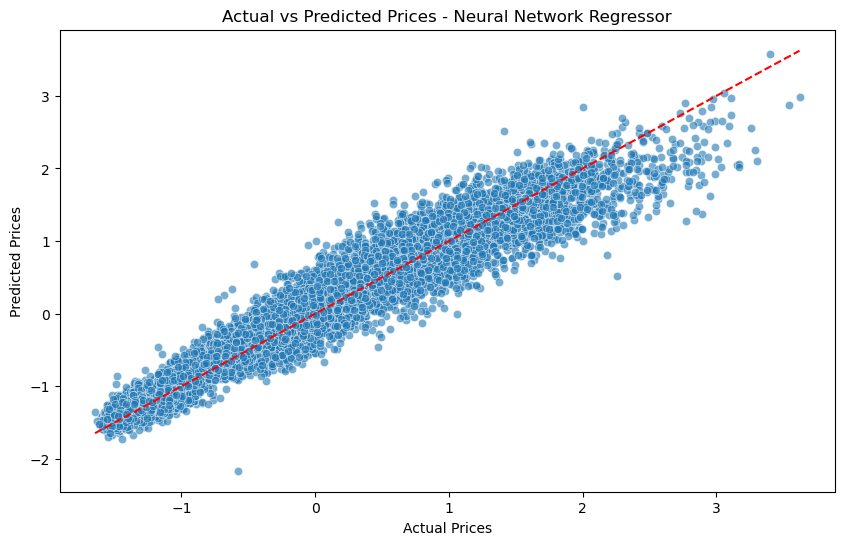

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Merge the dataframes
# df = pd.concat([df1, df2, df3], ignore_index=True)

# Function to run Neural Network Regression and calculate metrics
def run_neural_network_regressor(df):
    columns_to_use = ['TTT', 'LOS', 'score',
           'reviews', 'full_price',
           'Free_cancellation', 'No_payment', 'Breakfast', 'Option Member',
           'star_rating', 'location_rating',
           'km_from_center',
           'checkin_day', 'checkout_day', 'checkin_day_name_Friday',
           'checkin_day_name_Monday', 'checkin_day_name_Saturday',
           'checkin_day_name_Sunday', 'checkin_day_name_Thursday',
           'checkin_day_name_Tuesday', 'checkin_day_name_Wednesday',
           'checkin_day_name_nan', 'checkout_day_name_Friday',
           'checkout_day_name_Monday', 'checkout_day_name_Saturday',
           'checkout_day_name_Sunday', 'checkout_day_name_Thursday',
           'checkout_day_name_Tuesday', 'checkout_day_name_Wednesday',
           'checkout_day_name_nan', 'period_of_the_month_beginning of the month',
           'period_of_the_month_end of the month',
           'period_of_the_month_middle of the month']
    df = df[columns_to_use]
    
    # Keep only numeric columns
    df = df.select_dtypes(include=[np.number])
    
    # Remove columns with all NaN values
    df = df.dropna(axis=1, how='all')
    
    # Ensure there are no remaining NaN values
    imputer = SimpleImputer(strategy='mean')
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # Split the data into train and test sets
    X = df.drop(columns=['full_price'])
    y = df['full_price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Define the parameter grid for GridSearchCV
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }
    
    # Initialize Neural Network Regressor with GridSearchCV
    model = MLPRegressor(max_iter=500, random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    # Best model from GridSearchCV
    best_model = grid_search.best_estimator_
    
    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Training metrics
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    # Test metrics
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    results = {
        'Model': 'Neural Network Regressor',
        'Train R2': train_r2,
        'Train RMSE': train_rmse,
        'Train MSE': train_mse,
        'Train MAE': train_mae,
        'Test R2': test_r2,
        'Test RMSE': test_rmse,
        'Test MSE': test_mse,
        'Test MAE': test_mae,
        'Train Size': len(X_train),
        'Test Size': len(X_test),
        'Best Parameters': grid_search.best_params_
    }
    
    return results, y_test, y_test_pred

# Run Neural Network Regressor
results, y_test, y_test_pred = run_neural_network_regressor(df)

# Display results
print("Results for Neural Network Regressor with feature engineering and normalized data:")
print(results)

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices - Neural Network Regressor')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()

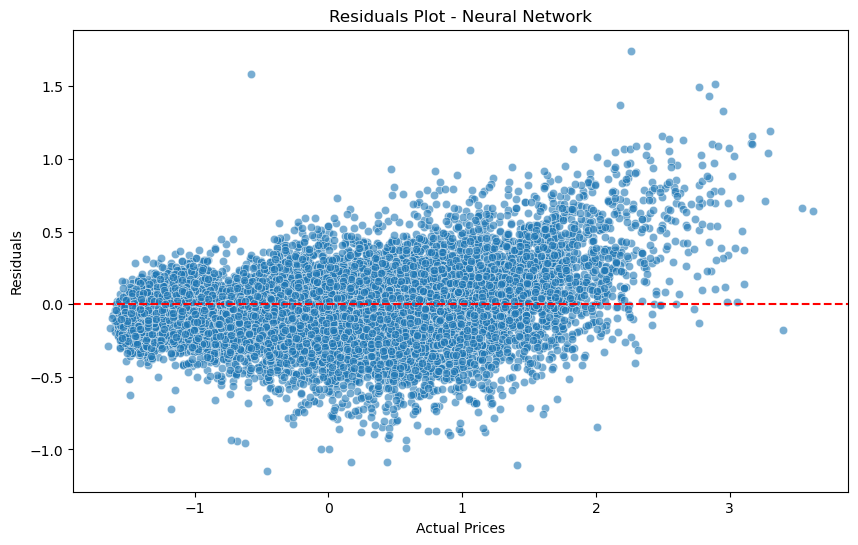

In [16]:
# Residual plot
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Residuals')
plt.title(f'Residuals Plot - Neural Network')
plt.show()

# Summery and Conclusions:

* The evaluation of the Neural Network Regressor model was conducted across four different configurations: original data, feature-engineered data, normalized data, and data that was both feature-engineered and normalized. The performance of the model was assessed using key metrics such as R-squared (R2), Root Mean Squared Error (RMSE), Mean Squared Error (MSE), and Mean Absolute Error (MAE) for both training and test sets.

Observations:
1. Original Data:
    * The model showed moderate performance with both training and test R2 values around 0.75, indicating a fair fit but significant room for improvement.
    
2. Feature Engineering:

    * The application of feature engineering substantially improved the model's performance. Both training and test R2 values increased to approximately 0.85, and errors (RMSE, MSE, and MAE) were notably reduced, demonstrating the effectiveness of this approach.

3. Data Normalization:

    * Normalization alone yielded even better results compared to feature engineering alone, with training and test R2 values around 0.90. This shows that normalizing the data significantly enhances the model's predictive capabilities.


4. Feature Engineering and Data Normalization:

    * The combination of feature engineering and data normalization provided the best results. The model achieved the highest R2 values (0.95 for training and 0.94 for testing) and the lowest errors among all configurations. This indicates that the synergistic effect of both techniques maximizes the model's accuracy and reliability.

* Impact of Data Preprocessing:

Data preprocessing techniques such as feature engineering and normalization play a crucial role in enhancing the performance of the Neural Network Regressor. Normalization had a more pronounced effect compared to feature engineering alone, but the best results were obtained when both techniques were combined.

* Model Robustness:

The Neural Network Regressor demonstrated robust performance improvements with appropriate preprocessing steps, suggesting its sensitivity to the quality and scaling of input data.

* Recommended Approach:

For optimal results, it is recommended to apply both feature engineering and normalization to the data before training the Neural Network Regressor. This approach maximizes predictive performance, as evidenced by the highest R2 and lowest error metrics observed in the combined configuration.
In summary, while the Neural Network Regressor performs reasonably well on unprocessed data, significant gains in accuracy and error reduction can be achieved through thoughtful preprocessing, with the combination of feature engineering and normalization yielding the best overall performance.